# Downloading and importing requiered libraries

In [1]:
from IPython.display import clear_output

!git clone https://github.com/sodeeplearning/simpletorch
!pip install ultralytics
!pip install supervision

clear_output(True)
print("All requiered modules have been downloaded")

All requiered modules have been downloaded


In [2]:
from ultralytics import YOLO
import simpletorch as ST
import io
import zipfile
import requests
import json
import os
import torch
from torchvision import transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import supervision as sv
import torchvision

print("All requiered libraries have been imported")

All requiered libraries have been imported


In [3]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=0)

# Downloading dataset

In [4]:
print("Downloading has been started")

url = "https://storage.yandexcloud.net/net-nomer-dataset/Net-Nomer-a-data_processing.zip"

response = requests.get(url)
zip = zipfile.ZipFile(io.BytesIO(response.content))
zip.extractall()
del zip

print("The dataset has been downloaded")
print("Starting detection dataset processing")

def image_num(path):
  last_slash = path.rfind('/')
  dot = path.rfind('.')
  return int(path[last_slash + 1:dot])

def string_perf(string):
    return int(string[string.find('>') + 1: string.rfind('<')])

def xml_perf(path):
    with open(path, 'r') as f:
        file = f.read()
        massive = file.split('\n')
        return (string_perf(massive[-7]) / 2592,
                string_perf(massive[-6]) / 1552,
                string_perf(massive[-5]) / 2592,
                string_perf(massive[-4]) / 1552)

def bboxes_dataset(path_to_folder):
  files = sorted(ST.getting_files(path_to_folder), key=image_num)
  answer_tensor = torch.zeros((len(files), 4))
  for ind, current_path in enumerate(files):
    answer_tensor[ind] = torch.tensor(xml_perf(current_path))
  print(files)
  return answer_tensor

train_bboxes_dataset = bboxes_dataset("Dataset/boxes")

print("The dataset has been performed")

The dataset has been downloaded
Starting detection dataset processing
['Dataset/boxes/0.xml', 'Dataset/boxes/1.xml', 'Dataset/boxes/2.xml', 'Dataset/boxes/3.xml', 'Dataset/boxes/4.xml', 'Dataset/boxes/5.xml', 'Dataset/boxes/6.xml', 'Dataset/boxes/7.xml', 'Dataset/boxes/8.xml', 'Dataset/boxes/9.xml', 'Dataset/boxes/10.xml', 'Dataset/boxes/11.xml', 'Dataset/boxes/12.xml', 'Dataset/boxes/13.xml', 'Dataset/boxes/14.xml', 'Dataset/boxes/15.xml', 'Dataset/boxes/16.xml', 'Dataset/boxes/17.xml', 'Dataset/boxes/18.xml', 'Dataset/boxes/19.xml', 'Dataset/boxes/20.xml', 'Dataset/boxes/21.xml', 'Dataset/boxes/22.xml', 'Dataset/boxes/23.xml', 'Dataset/boxes/24.xml', 'Dataset/boxes/25.xml', 'Dataset/boxes/26.xml', 'Dataset/boxes/27.xml', 'Dataset/boxes/28.xml', 'Dataset/boxes/29.xml', 'Dataset/boxes/30.xml', 'Dataset/boxes/31.xml', 'Dataset/boxes/32.xml', 'Dataset/boxes/33.xml', 'Dataset/boxes/34.xml', 'Dataset/boxes/35.xml', 'Dataset/boxes/36.xml', 'Dataset/boxes/37.xml', 'Dataset/boxes/38.xml', 'Da

# Getting model and prediction analizing

In [5]:
detection_model = YOLO('yolov9c.pt')

100%|██████████| 49.4M/49.4M [00:00<00:00, 426MB/s]


In [6]:
output = detection_model("Dataset/photo/0.jpg")
output


image 1/1 /content/Dataset/photo/0.jpg: 384x640 8 persons, 4 cars, 2 trucks, 2 backpacks, 1102.9ms
Speed: 12.5ms preprocess, 1102.9ms inference, 26.4ms postprocess per image at shape (1, 3, 384, 640)


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted p

In [7]:
train_bboxes_dataset

tensor([[0.3715, 0.6978, 0.4988, 0.7384],
        [0.4495, 0.8705, 0.6046, 0.9137],
        [0.3549, 0.6269, 0.4626, 0.6804],
        [0.2076, 0.8041, 0.3248, 0.8428],
        [0.4618, 0.7661, 0.6346, 0.8189],
        [0.3318, 0.7152, 0.6157, 0.7745],
        [0.3248, 0.5741, 0.4336, 0.6160],
        [0.2234, 0.6836, 0.3187, 0.7294],
        [0.2712, 0.8441, 0.4163, 0.8898],
        [0.1115, 0.5213, 0.2569, 0.5941],
        [0.3148, 0.6688, 0.4217, 0.7081],
        [0.4155, 0.7661, 0.5548, 0.8505],
        [0.2593, 0.7345, 0.3673, 0.7732],
        [0.3337, 0.6269, 0.4487, 0.6765],
        [0.7793, 0.3698, 1.1003, 0.4755],
        [0.3681, 0.6559, 0.4776, 0.6927],
        [0.2137, 0.5889, 0.3603, 0.6398],
        [0.1941, 0.6939, 0.2967, 0.7429],
        [0.3202, 0.6675, 0.4232, 0.7068],
        [0.3889, 0.6295, 0.4850, 0.6804],
        [0.2485, 0.7242, 0.3391, 0.7558],
        [0.8681, 0.8595, 1.0390, 0.9207],
        [0.3681, 0.5361, 0.4738, 0.5793],
        [0.2666, 0.5387, 0.3877, 0

#Adaptating dataset

## Getting dataset (Skip if loaded)

In [8]:
multy_factor = 5

In [9]:
def cropping_image(image, x_min, y_min, x_max, y_max, x_shape, y_shape):
  top = int(y_min * y_shape)
  left = int(x_min * x_shape)
  height = int((y_max - y_min) * y_shape)
  width = int((x_max - x_min) * x_shape)
  return transforms.functional.crop(img = image,
                                    top = top,
                                    left = left,
                                    height = height,
                                    width = width)

def detection_pred_processing(image_id):
  image_path = f"Dataset/photo/{image_id}.jpg"
  detection_output = detection_model(image_path)[0]
  answer_tensor = torch.zeros((0, 4))
  number_plate_coord = train_bboxes_dataset[image_id]
  nx_min, ny_min, nx_max, ny_max = number_plate_coord
  classes_with_number = [2, 3, 5, 7]
  transform = transforms.Resize((512, 512))
  answer_images = torch.zeros((0, 3, 512, 512))
  image_tensor = ST.jpg_tensor(image_path)
  y_shape, x_shape = image_tensor.shape[-2:]

  for current_class, (x_min, y_min, x_max, y_max) in zip(detection_output.boxes.cls, detection_output.boxes.xyxyn):
    if current_class.item() in classes_with_number:
      if x_min < nx_min and y_min < ny_min and x_max > nx_max and y_max > ny_max:
        coordinates = torch.tensor([(nx_min - x_min) / (x_max - x_min) * 0.99,
                                    (ny_min - y_min) / (y_max - y_min) * 0.99,
                                    (nx_max - x_min) / (x_max - x_min) * 1.01,
                                    (ny_max - y_min) / (y_max - y_min) * 1.01]).unsqueeze(0)
        answer_tensor = torch.cat((answer_tensor,
                                   coordinates),dim=0)
        adding_image = transform(cropping_image(image = image_tensor,
                                      x_min = x_min,
                                      y_min = y_min,
                                      x_max = x_max,
                                      y_max = y_max,
                                      x_shape = x_shape,
                                      y_shape = y_shape)).unsqueeze(0)
        answer_images = torch.cat((answer_images,
                                   adding_image), dim=0)

  return answer_images, answer_tensor

In [10]:
def get_dataset():
  answer_images = torch.zeros((0, 3, 512, 512))
  answer_bboxes = torch.zeros((0, 4))

  for i in range(202):
    print(f"{i + 1} sample now")
    current_images, current_bboxes = detection_pred_processing(i)
    answer_images = torch.cat((answer_images,
                               current_images), dim=0)
    answer_bboxes = torch.cat((answer_bboxes,
                               current_bboxes), dim=0)

  return answer_images, answer_bboxes

In [11]:
images_dataset, bboxes_dataset = get_dataset()
clear_output(True)
print("The dataset has been performed")

The dataset has been performed


In [12]:
def multy_image(image, multy_factor): # Increasing dataset size in multy_factor times
    augmentation = ST.transforms.Compose([
        ST.transforms.ToPILImage(),
        ST.transforms.ColorJitter(
            brightness=0.4,
            contrast=0.3,
            saturation=0.3,
            hue=0.1,
        ),
        ST.transforms.ToTensor()
    ])

    answer = torch.zeros((multy_factor, 3, 512, 512))

    for current_augmentation in range(multy_factor):
        answer[current_augmentation] = augmentation(image)

    return answer

def augment_dataset(dataset, multy_factor, num_of_images = 202):
    images_tensor = dataset

    train_images = torch.zeros((0, 3, 512, 512))
    for ind, current_image in enumerate(images_tensor):
        train_images = torch.cat([train_images, multy_image(
            image = current_image,
            multy_factor = multy_factor
        )], dim = 0)
    return train_images

augmented_images_dataset = augment_dataset(dataset = images_dataset,
                                           multy_factor = multy_factor,
                                           num_of_images = images_dataset.shape[0])

In [13]:
saving_dir = "drive/MyDrive/"
torch.save(augmented_images_dataset, saving_dir + "Detection_images.pt")
torch.save(bboxes_dataset, saving_dir + "Detection_bboxes.pt")

##loading dataset

In [4]:
multy_factor = 5

In [5]:
path_to_data = "drive/MyDrive/"
augmented_images_dataset = torch.load(path_to_data + "Detection_images.pt")
bboxes_dataset = torch.load(path_to_data + "Detection_bboxes.pt") * 512

In [6]:
train_images = augmented_images_dataset[:160 * multy_factor]
val_images = augmented_images_dataset[160 * multy_factor:]
train_bboxes = bboxes_dataset[:160]
val_bboxes = bboxes_dataset[160:]

#Getting CNN model

In [7]:
class CNN_Model (torch.nn.Module):
  def __init__(self):
    super().__init__()

    self.convolutions = torch.nn.Sequential(*[
        ST.Conv_Block(
            input_channels = 3,
            output_channels = 128,
        ),
        ST.Conv_Block(
            input_channels = 128,
            output_channels = 128,
        ),
        ST.Conv_Block(
            input_channels = 128,
            output_channels = 256,
        ),
        ST.Conv_Block(
            input_channels = 256,
            output_channels = 512,
        ),
        ST.Conv_Block(
            input_channels = 512,
            output_channels = 512,
        ),
        ST.Conv_Block(
            input_channels = 512,
            output_channels = 512,
        ),
        torch.nn.Flatten()
    ])

    self.fs = torch.nn.Sequential(*[
        torch.nn.Linear(32768, 100),
        torch.nn.ReLU(),
        torch.nn.Linear(100, 4),
    ])

  def forward(self, input_tensor):
    feature_map = self.convolutions(input_tensor)
    fs_bboxes = self.fs(feature_map)
    return fs_bboxes

cnn_model = CNN_Model().to(device)
print(f"{sum(p.numel() for p in cnn_model.parameters() if p.requires_grad)} params in model")
cnn_model

9627512 params in model


CNN_Model(
  (convolutions): Sequential(
    (0): Conv_Block(
      (Block): Sequential(
        (Dropout): Dropout(p=0.2, inplace=False)
        (Convolution Layer): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (Activation Func): ReLU()
        (Batch Normalization): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (MaxPooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): Conv_Block(
      (Block): Sequential(
        (Dropout): Dropout(p=0.2, inplace=False)
        (Convolution Layer): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (Activation Func): ReLU()
        (Batch Normalization): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (MaxPooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): Conv_Block(
      (Block): Sequential(
        (Dr

In [8]:
class CNN_Model_prior (torch.nn.Module):
  def __init__(self):
    super().__init__()

    self.convolutions = torch.nn.Sequential(*[
        ST.Conv_Block(
            input_channels = 3,
            output_channels = 64,
        ),
        ST.Conv_Block(
            input_channels = 64,
            output_channels = 128,
        ),
        ST.Conv_Block(
            input_channels = 128,
            output_channels = 256,
        ),
        ST.Conv_Block(
            input_channels = 256,
            output_channels = 512,
        ),
        ST.Conv_Block(
            input_channels = 512,
            output_channels = 512,
        ),
        ST.Conv_Block(
            input_channels = 512,
            output_channels = 512,
        ),
        torch.nn.Flatten()
    ])

    self.fs = torch.nn.Sequential(*[
        torch.nn.Linear(32768, 100),
        torch.nn.ReLU(),
        torch.nn.Linear(100, 4),
    ])

  def forward(self, input_tensor):
    feature_map = self.convolutions(input_tensor)
    fs_bboxes = self.fs(feature_map)
    return fs_bboxes

# Training CNN model

In [14]:
def dist_loss(bboxes_pred, bboxes_true):
  return torchvision.ops.distance_box_iou_loss(bboxes_pred, bboxes_true, reduction = 'mean')

In [11]:
def iou (bboxes_pred, bboxes_true):
  return torchvision.ops.complete_box_iou_loss(train_pred, train_true, reduction = 'mean').log() * -1

In [11]:
num_of_epochs = 2000
train_batch_size = 15
learning_rate = 2.5e-6
scheduler_gamma = 0.5
scheduler_freq = 400
change_loss = 200

show_every = 10
val_every = 10
val_batch_size = 15
best_val = 0.1

cnn_loss = torch.nn.L1Loss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = scheduler_gamma)

In [15]:
losses = {"train" : [], "val" : []}
cnn_model.train()

for epoch in range(1, num_of_epochs + 1):
  optimizer.zero_grad()
  train_batch = torch.randint(high = train_images.shape[0], size = [train_batch_size])

  train_pred = cnn_model(train_images[train_batch].to(device))
  train_true = train_bboxes[train_batch // multy_factor].to(device)

  train_loss = cnn_loss(train_pred, train_true) + dist_loss(train_pred, train_true)

  train_loss.backward()
  optimizer.step()

  losses["train"].append(train_loss.item())

  if epoch % val_every == 0:
    with torch.no_grad():
      val_batch = torch.randint(high = val_images.shape[0], size = [val_batch_size])
      val_pred = cnn_model(val_images[val_batch].to(device))
      val_true = val_bboxes[val_batch // multy_factor].to(device)

      val_loss = cnn_loss(val_pred, val_true) + dist_loss(train_pred, train_true)

      losses["val"].append(val_loss.item())
      print(val_loss.item())
      if (val_loss.item() < best_val):
        torch.save(cnn_model.state_dict(), "drive/MyDrive/cnn_best_weights.pt")
        best_val = val_loss.item()
        print("The weights have been updated")

  if epoch % scheduler_freq == 0:
    scheduler.step()

  if epoch % show_every == 0:
      clear_output(True)
      fig, ax = plt.subplots(figsize=(30, 10))
      plt.title("Loss graph")
      plt.plot(losses["train"], ".-", label="Training Loss")
      plt.plot(torch.arange(0, epoch, show_every), losses["val"], ".-", label="Validation Loss")
      plt.xlabel("Iteration")
      plt.ylabel("Loss")
      plt.legend()
      plt.grid()
      plt.show()


OutOfMemoryError: CUDA out of memory. Tried to allocate 480.00 MiB. GPU 

In [22]:
scheduler.get_last_lr()

[2.5e-06]

# Checking CNN training

In [ ]:
def adjusting_contrast(images):
  return transforms.functional.adjust_contrast(img = images,
                                               contrast_factor = 4.)
def adjusting_brightness(images):
  return transforms.functional.adjust_brightness(img = images,
                                                 brightness_factor = 2.)
def adjust_image(image):
  return adjusting_contrast(adjusting_brightness(image))

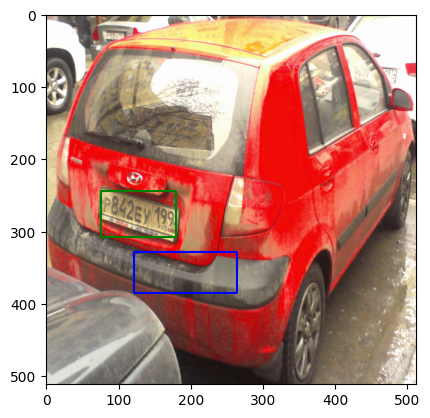

In [18]:
def cnn_pred(image_id, color_pred = 'blue', color_right = 'green'):
  #cnn_model.load_state_dict(torch.load("best_weights.pt"))
  image = val_images[image_id]
  #image = adjust_image(val_images[image_id])
  cnn_model.train()
  annotator = sv.BoxAnnotator()
  transform = transforms.Resize((512, 512))
  to_pil = transforms.ToPILImage()

  image_tensor = transform(image.unsqueeze(0)).to(device)
  coordinates = (cnn_model(image_tensor)).tolist()
  rx0, ry0, rx1, ry1 = val_bboxes[image_id // multy_factor].clone()

  x0, y0, x1, y1 = coordinates[0]
  x_min = min(x0, x1)
  x_max = max(x0, x1)
  y_min = min(y0, y1)
  y_max = max(y0, y1)
  ST.imshow(image)
  plt.vlines(x_min, y_min, y_max, color=color_pred)
  plt.vlines(x_max, y_max, y_min, color=color_pred)
  plt.hlines(y_min, x_min, x_max, color=color_pred)
  plt.hlines(y_max, x_max, x_min, color=color_pred)

  plt.vlines(rx0, ry0, ry1, color=color_right)
  plt.vlines(rx1, ry1, ry0, color=color_right)
  plt.hlines(ry0, rx0, rx1, color=color_right)
  plt.hlines(ry1, rx1, rx0, color=color_right)

  return coordinates

pred_bboxes_s = cnn_pred(20)

In [9]:
cnn_model.load_state_dict(torch.load("drive/MyDrive/weights_2300.pt"))

<All keys matched successfully>

In [21]:
torch.save(cnn_model.cpu().state_dict(), "drive/MyDrive/weights_2300.pt")

In [12]:
cnn_model.cuda()

CNN_Model(
  (convolutions): Sequential(
    (0): Conv_Block(
      (Block): Sequential(
        (Dropout): Dropout(p=0.2, inplace=False)
        (Convolution Layer): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (Activation Func): ReLU()
        (Batch Normalization): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (MaxPooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): Conv_Block(
      (Block): Sequential(
        (Dropout): Dropout(p=0.2, inplace=False)
        (Convolution Layer): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (Activation Func): ReLU()
        (Batch Normalization): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (MaxPooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): Conv_Block(
      (Block): Sequential(
        (Dr

In [15]:
torch.save(cnn_model.cpu(), "cnn.pt")

# Using the model

In [16]:
import torch
import ultralytics
import matplotlib.pyplot as plt
from torchvision import transforms

class Number_detection:
  def __init__(self,
               path_to_model,
               yolo_version = "yolov9c.pt",
               device = 'cpu'):
    self.device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
    self.detection_model = YOLO(yolo_version)
    self.cnn_model = torch.load(path_to_model).to(self.device)
    self.cnn_model.train()

  def cropping_image(self, image, x_min, y_min, x_max, y_max, x_shape, y_shape):
    top = int(y_min * y_shape)
    left = int(x_min * x_shape)
    height = int((y_max - y_min) * y_shape)
    width = int((x_max - x_min) * x_shape)
    return transforms.functional.crop(img = image,
                                      top = top,
                                      left = left,
                                      height = height,
                                      width = width)

  def detection_perform(self, image_path, min_size = 0.17):
    detection_output = self.detection_model(image_path)[0]
    classes_with_number = [2, 3, 5, 7]
    transform = transforms.Resize((512, 512))
    answer_images = torch.zeros((0, 3, 512, 512))
    image_tensor = ST.jpg_tensor(image_path)
    y_shape, x_shape = image_tensor.shape[-2:]
    num_of_preds = 0

    for current_class, (x_min, y_min, x_max, y_max) in zip(detection_output.boxes.cls, detection_output.boxes.xyxyn):
      if current_class.item() in classes_with_number and x_max - x_min >= min_size and y_max - y_min >= min_size:
        adding_image = transform(self.cropping_image(image = image_tensor,
                                                     x_min = x_min,
                                                     y_min = y_min,
                                                     x_max = x_max,
                                                     y_max = y_max,
                                                     x_shape = x_shape,
                                                     y_shape = y_shape)).unsqueeze(0)
        answer_images = torch.cat((answer_images,
                                   adding_image), dim=0)
        num_of_preds += 1
    return answer_images, num_of_preds

  def plot_boxes(self, image, coordinates, color='red'):
    x0, y0, x1, y1 = coordinates
    x_min = min(x0, x1)
    x_max = max(x0, x1)
    y_min = min(y0, y1)
    y_max = max(y0, y1)
    ST.imshow(image)
    plt.vlines(x_min, y_min, y_max, color=color)
    plt.vlines(x_max, y_max, y_min, color=color)
    plt.hlines(y_min, x_min, x_max, color=color)
    plt.hlines(y_max, x_max, x_min, color=color)

  def load_weights(self, path_to_weights):
    self.cnn_model.load_state_dict(torch.load(path_to_weights))

  def save_cnn_model(self, saving_path):
    torch.save(self.cnn_model, saving_path)

  def image_pred (self, image_path, show = True, color = 'red', min_size = 0.17):
    images_tensor, num_of_preds = self.detection_perform(image_path, min_size=min_size)
    answer_bboxes = (self.cnn_model((images_tensor.to(self.device)) % 1)).tolist()
    return images_tensor, answer_bboxes

number_detector = Number_detection(path_to_model="cnn.pt")


image 1/1 /content/car_example_1.jpg: 480x640 1 car, 1 potted plant, 39.6ms
Speed: 2.0ms preprocess, 39.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


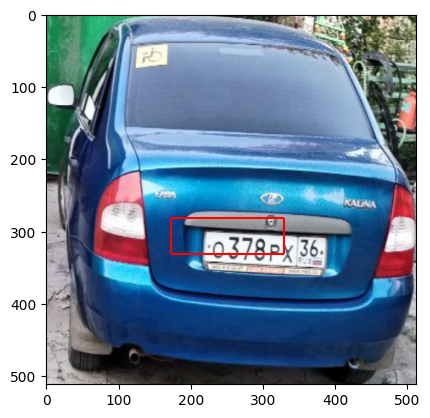

In [20]:
images, bboxes = number_detector.image_pred("car_example_1.jpg")
id = 0
number_detector.plot_boxes(image = images[id],
                           coordinates = bboxes[id])

In [46]:
number_detector.load_weights("drive/MyDrive/weights_1300.pt")